In [1]:
%config IPCompleter.greedy=True


In [2]:
import pandas as pd

df_train = pd.read_csv('train_kaggle.csv')
df_train

,Id,label
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,1
9,9,0


In [3]:
df_train['label'].describe()

count    30336.000000
mean         0.077664
std          0.267646
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: label, dtype: float64

In [4]:
import seaborn as sns

sns.distplot(df_train['label']);

In [5]:
import numpy as np

train0 = np.load('train/train/0.npy')
train0

array([[nan, nan,  1., ..., nan, nan, nan],
       [nan, nan,  2., ..., 19., nan, nan],
       [nan, nan,  3., ..., 22., nan, nan],
       ...,
       [nan, nan, 52., ..., 26., nan, nan],
       [nan, nan, 53., ..., 22., nan, nan],
       [nan, nan, 54., ..., 18., nan, nan]])

In [6]:
def load_dataframe(id):
    train_data = np.load("train/train/{}.npy".format(id))
    return pd.DataFrame(data=train_data)

In [7]:
def get_missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [8]:
def clear_missing_data(df, missing_indices):
    df = df.drop(missing_indices,1)
    # for col in df_temp.columns:
    #    df = df.drop(df.loc[df[col].isnull()].index)
    for col in df.columns:
        count = df[col].isnull().sum().max()
        df[col] = df[col].fillna(np.mean(df[col])) 
        df[col] = df[col].fillna(0) # if np mean is NA, then replace 0 
    return df

In [9]:
df8 = load_dataframe(8)
missing_df8 = get_missing_data(df8)
missing_indices = []
missing_indices = missing_df8[missing_df8['Percent'] > 0.8].index # .append(pd.Index([11,33,35]))
cleaned_df8 = clear_missing_data(df8, missing_indices)
missing_indices

Int64Index([ 0, 25,  4,  7, 34, 10, 30, 28, 16, 20, 38, 32, 14,  1, 19,  9, 21,
            27, 23, 36,  5,  6, 31,  8, 12, 22, 26, 18],
           dtype='int64')

In [ ]:
cleaned_df8

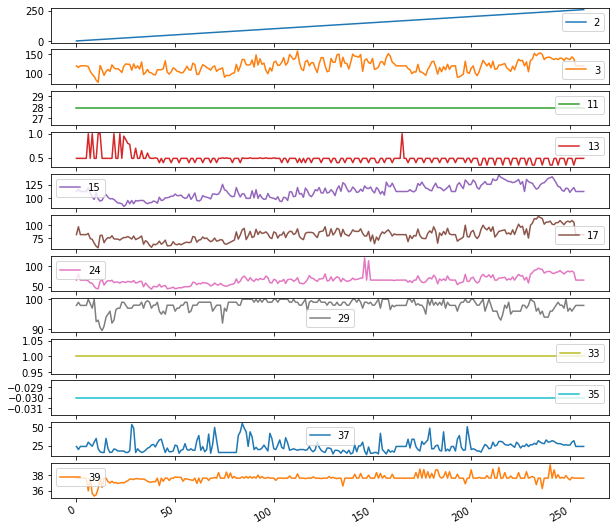

In [10]:
import matplotlib.pyplot as plt
cleaned_df8.plot(subplots=True, sharex=True, figsize=(10,10))
plt.show()

In [11]:
y = df_train['label']
y = y.values
y

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [ ]:
dataframes = []
for id in df_train['Id']:
    dfi = clear_missing_data(load_dataframe(id), missing_indices)
    if dfi.empty:
        print("{}:".format(id))
        continue
    dataframes.append(dfi.values)

In [ ]:
df_train_all = np.array(dataframes)
np.save('df_train_all', df_train_all)

In [12]:
df_train_all = np.load('df_train_all.npy',allow_pickle=True)

In [13]:
print(df_train_all.shape)

(30336,)


In [14]:
def pad_data(dfs):
    data = []
    ROW_SIZE = 200
    for i in range(len(dfs)):
        df = dfs[i]
        diff = ROW_SIZE - df.shape[0]
        if diff > 0:
            halfDiff = int(diff / 2)
            df = np.pad(df, [(0,diff), (0,0)], 'constant')
        else:
            df = df[:ROW_SIZE]
        data.append(df)
    data = np.stack(data)
    return data

In [15]:
XTrain_pad = pad_data(df_train_all)

In [16]:
XTrain_pad.shape

(30336, 200, 40)

In [17]:
XTrain = np.delete(XTrain_pad, missing_indices, 2)
XTrain.shape

(30336, 200, 12)

In [ ]:
def load_dataframe_test(id):
    train_data = np.load("test/test/{}.npy".format(id))
    return pd.DataFrame(data=train_data)

df_test = pd.read_csv('sample_solution.csv')
dataframestest = []
for id in df_test['Id']:
    dfi = clear_missing_data(load_dataframe_test(id), missing_indices)
    if dfi.empty:
        print("{}:".format(id))
        continue
    dataframestest.append(dfi.values)

df_test_all = np.array(dataframestest)
df_test_all

In [ ]:
np.save('df_test_all', df_test_all)

In [28]:
df_test_all = np.load('df_test_all.npy',allow_pickle=True)

In [ ]:
XTest = pad_data(dataframestest)

In [ ]:
XTest = np.delete(XTest, missing_indices, 2)
XTest.shape

In [ ]:
import numpy as np
import autokeras as ak
from keras.datasets import mnist

# Build model and train.
automodel = ak.AutoModel(
   inputs=[ak.StructuredDataInput()],
   outputs=[ak.ClassificationHead(loss='binary_crossentropy',
                                  metrics=['accuracy'])])
automodel.fit([XTrain],
              [y],
              validation_split=0.2)

In [ ]:
import tensorflow as tf
from tensorflow import keras

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(XTrain.shape[1], XTrain.shape[2])),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(XTrain, y, epochs=5)

In [ ]:
YTest = model.predict(XTest)


In [ ]:
df_test['Predicted'] = YTest
df_test

In [ ]:
df_test.to_csv('test.csv', index=False)

In [ ]:
np.save(.XTrain.values)

In [32]:
import numpy as np
import autokeras as ak
from keras.datasets import mnist

# Prepare the data.
(x_train, y_classification), (x_test, y_test) = mnist.load_data()
x_image = x_train.reshape(x_train.shape + (1,))
x_test = x_test.reshape(x_test.shape + (1,))

x_structured = np.random.rand(x_train.shape[0], 100)
y_regression = np.random.rand(x_train.shape[0], 1)

y_classification

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
# Build model and train.
automodel = ak.AutoModel(
   inputs=[ak.ImageInput(),
           ak.StructuredDataInput()],
   outputs=[ak.RegressionHead(metrics=['mae']),
            ak.ClassificationHead(loss='categorical_crossentropy',
                                  metrics=['accuracy'])])
automodel.fit([x_image, x_structured],
              [y_regression, y_classification],validation_split=0.2)

In [ ]:
print (x_structured.shape)